<a href="https://colab.research.google.com/github/tak34/atmacup-15/blob/main/val13_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

別ファイルで特徴抽出したデータを結合し、バリデーションとsubの作成を行う。  
以下の2パターンでモデルを分けている。  
- seen  : trainとtestで共通して出現するユーザーに対する予測 (約80%)。バリデーションはkfoldで行う。
- unseen: testのみに出現するユーザーに対する予測（約20%）。バリデーションはStratifiedGroupKFoldで行う。

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedGroupKFold
from tqdm.notebook import tqdm

warnings.simplefilter('ignore')

In [ ]:
# Config
# subの保存について
SEED = 42
SAVE_SUB = True
SAVE_SUB_DIR = Path("/content/drive/MyDrive/Kaggle/atmacup#15/proc/sub")
SUB_FILE_NAME = f"val13_2_seed{SEED}"

In [ ]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

fix_all_seeds(SEED)

# データ読み込み

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Kaggle/atmacup#15/raw/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Kaggle/atmacup#15/raw/test.csv")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/atmacup#15/raw/sample_submission.csv")

# 別ファイルで特徴抽出したファイル
# 「FE1_3_anime_mod.ipynb」で作成
anime = pd.read_pickle("/content/drive/MyDrive/Kaggle/atmacup#15/proc/fe/FE1_3_anime_20230722.pkl")
# 「FE3_user_attribution.ipynb」で作成
user_attribution = pd.read_pickle("/content/drive/MyDrive/Kaggle/atmacup#15/proc/fe/FE3_user_attribution_20230717.pkl")
# 「try3_2_anime2vec.ipynb」で作成
anime2gensaku = pd.read_pickle("/content/drive/MyDrive/Kaggle/atmacup#15/proc/try3-2_anime2gensaku.pkl")
user_w2v_score = pd.read_pickle("/content/drive/MyDrive/Kaggle/atmacup#15/proc/try3/try3-2_df_w2v_user_score_mod.pkl")
anime_w2v_score = pd.read_pickle("/content/drive/MyDrive/Kaggle/atmacup#15/proc/try3/try3-2_df_w2v_anime_score_mod.pkl")
user_w2v_withoutScore = pd.read_pickle("/content/drive/MyDrive/Kaggle/atmacup#15/proc/try3/try3-2_df_w2v_user_withoutScore_mod.pkl")
anime_w2v_withoutScore = pd.read_pickle("/content/drive/MyDrive/Kaggle/atmacup#15/proc/try3/try3-2_df_w2v_anime_withoutScore_mod.pkl")

# 前処理

## 特徴量の結合

In [ ]:
# animeで使用する特徴量
features_anime = [
    'members_scaled',
    'completed_scaled',
    'watching_per_members',
    'completed_per_members',
    'on_hold_per_members',
    'dropped_per_members',
    'plan_to_watch_per_members',
    'label_type',
    'episodes',
    'aired_from',
    'aired_to',
    'aired_duration',
    'label_source',
    'label_rating',
    'ohe_genres_Action',
    'ohe_genres_Adventure',
    # 'ohe_genres_Cars',      # 数少ない&予測誤差大きい。過学習してそうなので消す
    'ohe_genres_Comedy',
    # 'ohe_genres_Dementia',  # 数少ない&予測誤差大きい。過学習してそうなので消す
    'ohe_genres_Demons',
    'ohe_genres_Drama',
    'ohe_genres_Ecchi',
    'ohe_genres_Fantasy',
    'ohe_genres_Game',
    'ohe_genres_Harem',
    # 'ohe_genres_Hentai',    # 数少ない&予測誤差大きい。過学習してそうなので消す
    'ohe_genres_Historical',
    'ohe_genres_Horror',
    'ohe_genres_Josei',
    'ohe_genres_Kids',
    'ohe_genres_Magic',
    'ohe_genres_Martial Arts',
    'ohe_genres_Mecha',
    'ohe_genres_Military',
    'ohe_genres_Music',
    'ohe_genres_Mystery',
    'ohe_genres_Parody',
    'ohe_genres_Police',
    'ohe_genres_Psychological',
    'ohe_genres_Romance',
    'ohe_genres_Samurai',
    'ohe_genres_School',
    'ohe_genres_Sci-Fi',
    'ohe_genres_Seinen',
    'ohe_genres_Shoujo',
    'ohe_genres_Shoujo Ai',
    'ohe_genres_Shounen',
    # 'ohe_genres_Shounen Ai', # 数少ない&予測誤差大きい。過学習してそうなので消す
    'ohe_genres_Slice of Life',
    'ohe_genres_Space',
    'ohe_genres_Sports',
    'ohe_genres_Super Power',
    'ohe_genres_Supernatural',
    'ohe_genres_Thriller',
    'ohe_genres_Vampire',
    # 'ohe_genres_Yaoi',      # 数少ない&予測誤差大きい。過学習してそうなので消す
    'svd_producers_mod_0',
    'svd_producers_mod_1',
    'svd_producers_mod_2',
    'svd_producers_mod_3',
    'svd_producers_mod_4',
    'svd_producers_mod_5',
    'svd_producers_mod_6',
    'svd_producers_mod_7',
    'svd_producers_mod_8',
    'svd_producers_mod_9',
    'ohe_licensors_4Kids Entertainment',
    'ohe_licensors_ADV Films',
    'ohe_licensors_Anchor Bay Films',
    'ohe_licensors_AnimEigo',
    'ohe_licensors_Aniplex of America',
    'ohe_licensors_Bandai',
    'ohe_licensors_Bandai Entertainment',
    'ohe_licensors_Bandai Visual USA',
    'ohe_licensors_Central Park Media',
    'ohe_licensors_Crimson Star Media',
    'ohe_licensors_Crunchyroll',
    'ohe_licensors_DiC Entertainment',
    'ohe_licensors_Discotek Media',
    'ohe_licensors_DreamWorks',
    'ohe_licensors_Eleven Arts',
    'ohe_licensors_Enoki Films',
    'ohe_licensors_Flatiron Film Company',
    'ohe_licensors_Funimation',
    'ohe_licensors_GKIDS',
    'ohe_licensors_Geneon Entertainment USA',
    'ohe_licensors_Inc.',
    'ohe_licensors_Kadokawa Pictures USA',
    'ohe_licensors_Maiden Japan',
    'ohe_licensors_Manga Entertainment',
    'ohe_licensors_Media Blasters',
    'ohe_licensors_Miramax Films',
    'ohe_licensors_NBCUniversal Entertainment Japan',
    'ohe_licensors_NIS America',
    'ohe_licensors_NYAV Post',
    'ohe_licensors_Nelvana',
    'ohe_licensors_Netflix',
    'ohe_licensors_Nozomi Entertainment',
    'ohe_licensors_Pied Piper',
    'ohe_licensors_Ponycan USA',
    'ohe_licensors_Saban Entertainment',
    'ohe_licensors_Sentai Filmworks',
    'ohe_licensors_Shout! Factory',
    'ohe_licensors_Sony Pictures Entertainment',
    'ohe_licensors_Super Techno Arts',
    'ohe_licensors_Synch-Point',
    'ohe_licensors_The Pokemon Company International',
    'ohe_licensors_Tokyopop',
    'ohe_licensors_Unknown',
    'ohe_licensors_Urban Vision',
    'ohe_licensors_VIZ Media',
    'ohe_licensors_Walt Disney Studios',
    'ohe_licensors_Warner Bros. Japan',
    'ohe_licensors_Warner Bros. Pictures',
    'ohe_licensors_feel.',
    'svd_studios_0',
    'svd_studios_1',
    'svd_studios_2',
    'svd_studios_3',
    'svd_studios_4',
    'svd_studios_5',
    'svd_studios_6',
    'svd_studios_7',
    'svd_studios_8',
    'svd_studios_9'
 ]

In [ ]:
# 特徴抽出済みのデータを結合する
# anime
train = train.merge(anime[["anime_id"]+features_anime],
                    on="anime_id",
                    how="left")
test = test.merge(anime[["anime_id"]+features_anime],
                  on="anime_id",
                  how="left")

print(train.shape)
print(test.shape)
train.head()

(136401, 123)
(117676, 122)


,user_id,anime_id,score,members_scaled,completed_scaled,watching_per_members,completed_per_members,on_hold_per_members,dropped_per_members,plan_to_watch_per_members,...,svd_studios_0,svd_studios_1,svd_studios_2,svd_studios_3,svd_studios_4,svd_studios_5,svd_studios_6,svd_studios_7,svd_studios_8,svd_studios_9
0,0008e10fb39e55447333,0669cc0219d468761195,2,1.431216,0.907258,0.119432,0.707157,0.019580,0.010569,0.143262,...,3.284481e-06,1.585605e-05,1.691385e-05,2.291201e-05,-1.954796e-04,1.192761e-04,2.643910e-04,2.978937e-04,-1.031235e-03,2.439473e-02
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10,1.660035,1.039773,0.045617,0.733893,0.020507,0.027762,0.172221,...,1.837359e-09,4.563032e-09,4.085071e-09,-4.389935e-08,-1.646979e-07,9.250477e-08,3.434337e-09,5.251271e-08,-2.809585e-07,1.338807e-07
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1,-0.303764,0.165492,0.037460,0.822841,0.005510,0.068559,0.065630,...,8.580825e-11,-4.310467e-11,-1.089889e-11,4.582223e-10,1.333206e-09,-1.353710e-09,-5.350045e-10,2.640980e-10,2.190049e-09,-1.900151e-09
3,0008e10fb39e55447333,2290175205d55e81b197,8,2.492015,1.453149,0.054180,0.750422,0.020803,0.015299,0.159296,...,-7.126595e-06,-1.373755e-05,-2.797610e-05,-1.961799e-04,1.174277e-04,-6.632702e-03,9.852846e-01,1.693871e-01,-7.237710e-04,-5.326699e-04
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9,-0.740910,-0.028956,0.016077,0.844298,0.005157,0.003893,0.130575,...,1.259131e-03,6.692107e-03,9.960652e-01,-7.874581e-02,-2.696650e-05,-9.713901e-04,5.441507e-05,8.761767e-07,6.634946e-05,-1.304064e-04


In [ ]:
# 特徴抽出済みのデータを結合する
# user_attribution
train = train.merge(user_attribution,
                    on="user_id",
                    how="left")
test = test.merge(user_attribution,
                  on="user_id",
                  how="left")

print(train.shape)
print(test.shape)
train.head()

(136401, 133)
(117676, 132)


,user_id,anime_id,score,members_scaled,completed_scaled,watching_per_members,completed_per_members,on_hold_per_members,dropped_per_members,plan_to_watch_per_members,...,svd_userAttribution_0,svd_userAttribution_1,svd_userAttribution_2,svd_userAttribution_3,svd_userAttribution_4,svd_userAttribution_5,svd_userAttribution_6,svd_userAttribution_7,svd_userAttribution_8,svd_userAttribution_9
0,0008e10fb39e55447333,0669cc0219d468761195,2,1.431216,0.907258,0.119432,0.707157,0.019580,0.010569,0.143262,...,2.320282,0.215112,-2.137685,-0.50411,-1.509799,-0.832248,-0.025398,0.70708,-0.225723,0.032335
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10,1.660035,1.039773,0.045617,0.733893,0.020507,0.027762,0.172221,...,2.320282,0.215112,-2.137685,-0.50411,-1.509799,-0.832248,-0.025398,0.70708,-0.225723,0.032335
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1,-0.303764,0.165492,0.037460,0.822841,0.005510,0.068559,0.065630,...,2.320282,0.215112,-2.137685,-0.50411,-1.509799,-0.832248,-0.025398,0.70708,-0.225723,0.032335
3,0008e10fb39e55447333,2290175205d55e81b197,8,2.492015,1.453149,0.054180,0.750422,0.020803,0.015299,0.159296,...,2.320282,0.215112,-2.137685,-0.50411,-1.509799,-0.832248,-0.025398,0.70708,-0.225723,0.032335
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9,-0.740910,-0.028956,0.016077,0.844298,0.005157,0.003893,0.130575,...,2.320282,0.215112,-2.137685,-0.50411,-1.509799,-0.832248,-0.025398,0.70708,-0.225723,0.032335


In [ ]:
# 原作名をマージする
train = train.merge(anime2gensaku,
                    on="anime_id",
                    how="left")
test = test.merge(anime2gensaku,
                  on="anime_id",
                  how="left")

print(train.shape)
print(test.shape)
train.head()

(136401, 134)
(117676, 133)


,user_id,anime_id,score,members_scaled,completed_scaled,watching_per_members,completed_per_members,on_hold_per_members,dropped_per_members,plan_to_watch_per_members,...,svd_userAttribution_1,svd_userAttribution_2,svd_userAttribution_3,svd_userAttribution_4,svd_userAttribution_5,svd_userAttribution_6,svd_userAttribution_7,svd_userAttribution_8,svd_userAttribution_9,original_work_name
0,0008e10fb39e55447333,0669cc0219d468761195,2,1.431216,0.907258,0.119432,0.707157,0.019580,0.010569,0.143262,...,0.215112,-2.137685,-0.50411,-1.509799,-0.832248,-0.025398,0.70708,-0.225723,0.032335,ジョジョの奇妙な冒険 ダイヤモンドは砕けない
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10,1.660035,1.039773,0.045617,0.733893,0.020507,0.027762,0.172221,...,0.215112,-2.137685,-0.50411,-1.509799,-0.832248,-0.025398,0.70708,-0.225723,0.032335,DEVILMAN crybaby
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1,-0.303764,0.165492,0.037460,0.822841,0.005510,0.068559,0.065630,...,0.215112,-2.137685,-0.50411,-1.509799,-0.832248,-0.025398,0.70708,-0.225723,0.032335,ぼくのぴこ
3,0008e10fb39e55447333,2290175205d55e81b197,8,2.492015,1.453149,0.054180,0.750422,0.020803,0.015299,0.159296,...,0.215112,-2.137685,-0.50411,-1.509799,-0.832248,-0.025398,0.70708,-0.225723,0.032335,モブサイコ100 II
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9,-0.740910,-0.028956,0.016077,0.844298,0.005157,0.003893,0.130575,...,0.215112,-2.137685,-0.50411,-1.509799,-0.832248,-0.025398,0.70708,-0.225723,0.032335,はじめの一歩 Rising


In [ ]:
# 特徴抽出済みのデータを結合する
# user_w2v
train = train.merge(user_w2v_score,
                    on="user_id",
                    how="left")
test = test.merge(user_w2v_score,
                  on="user_id",
                  how="left")

print(train.shape)
print(test.shape)
train.head()

(136401, 198)
(117676, 197)


,user_id,anime_id,score,members_scaled,completed_scaled,watching_per_members,completed_per_members,on_hold_per_members,dropped_per_members,plan_to_watch_per_members,...,user_factor_54,user_factor_55,user_factor_56,user_factor_57,user_factor_58,user_factor_59,user_factor_60,user_factor_61,user_factor_62,user_factor_63
0,0008e10fb39e55447333,0669cc0219d468761195,2,1.431216,0.907258,0.119432,0.707157,0.019580,0.010569,0.143262,...,0.678634,1.454493,0.522011,0.172755,0.104297,-0.013445,0.156669,0.330454,0.394639,0.141609
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10,1.660035,1.039773,0.045617,0.733893,0.020507,0.027762,0.172221,...,0.678634,1.454493,0.522011,0.172755,0.104297,-0.013445,0.156669,0.330454,0.394639,0.141609
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1,-0.303764,0.165492,0.037460,0.822841,0.005510,0.068559,0.065630,...,0.678634,1.454493,0.522011,0.172755,0.104297,-0.013445,0.156669,0.330454,0.394639,0.141609
3,0008e10fb39e55447333,2290175205d55e81b197,8,2.492015,1.453149,0.054180,0.750422,0.020803,0.015299,0.159296,...,0.678634,1.454493,0.522011,0.172755,0.104297,-0.013445,0.156669,0.330454,0.394639,0.141609
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9,-0.740910,-0.028956,0.016077,0.844298,0.005157,0.003893,0.130575,...,0.678634,1.454493,0.522011,0.172755,0.104297,-0.013445,0.156669,0.330454,0.394639,0.141609


In [ ]:
# 特徴抽出済みのデータを結合する
# anime_w2v
train = train.merge(anime_w2v_score,
                    on="original_work_name",
                    how="left")
test = test.merge(anime_w2v_score,
                  on="original_work_name",
                  how="left")

print(train.shape)
print(test.shape)
train.head()

(136401, 262)
(117676, 261)


,user_id,anime_id,score,members_scaled,completed_scaled,watching_per_members,completed_per_members,on_hold_per_members,dropped_per_members,plan_to_watch_per_members,...,item_factor_54,item_factor_55,item_factor_56,item_factor_57,item_factor_58,item_factor_59,item_factor_60,item_factor_61,item_factor_62,item_factor_63
0,0008e10fb39e55447333,0669cc0219d468761195,2,1.431216,0.907258,0.119432,0.707157,0.019580,0.010569,0.143262,...,0.451706,3.027462,0.517448,-0.180926,1.857439,0.490624,1.114930,1.673540,0.107289,0.914681
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10,1.660035,1.039773,0.045617,0.733893,0.020507,0.027762,0.172221,...,-1.326058,1.431511,1.512789,2.306756,-0.083732,-0.729480,1.449708,-0.019035,1.222205,0.479021
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1,-0.303764,0.165492,0.037460,0.822841,0.005510,0.068559,0.065630,...,-1.258517,1.519992,-0.313069,-0.084738,-0.094211,-0.162789,1.173178,-0.592232,-0.162126,-0.449697
3,0008e10fb39e55447333,2290175205d55e81b197,8,2.492015,1.453149,0.054180,0.750422,0.020803,0.015299,0.159296,...,-0.824522,0.348560,2.326352,0.059269,0.690022,0.295823,0.239525,-0.189477,1.215872,0.428804
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9,-0.740910,-0.028956,0.016077,0.844298,0.005157,0.003893,0.130575,...,0.194733,1.284768,0.653766,-1.505827,0.185071,0.262212,0.527191,-0.516012,-1.872142,-0.336101


In [ ]:
# 特徴抽出済みのデータを結合する
# user_w2v_withoutScore
train = train.merge(user_w2v_withoutScore,
                    on="user_id",
                    how="left")
test = test.merge(user_w2v_withoutScore,
                  on="user_id",
                  how="left")

print(train.shape)
print(test.shape)
train.head()

(136401, 326)
(117676, 325)


,user_id,anime_id,score,members_scaled,completed_scaled,watching_per_members,completed_per_members,on_hold_per_members,dropped_per_members,plan_to_watch_per_members,...,user_factor_withoutScore_54,user_factor_withoutScore_55,user_factor_withoutScore_56,user_factor_withoutScore_57,user_factor_withoutScore_58,user_factor_withoutScore_59,user_factor_withoutScore_60,user_factor_withoutScore_61,user_factor_withoutScore_62,user_factor_withoutScore_63
0,0008e10fb39e55447333,0669cc0219d468761195,2,1.431216,0.907258,0.119432,0.707157,0.019580,0.010569,0.143262,...,-0.122901,0.236327,-0.290799,0.207217,-0.053797,0.170556,-0.14713,0.421226,0.095676,0.644251
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10,1.660035,1.039773,0.045617,0.733893,0.020507,0.027762,0.172221,...,-0.122901,0.236327,-0.290799,0.207217,-0.053797,0.170556,-0.14713,0.421226,0.095676,0.644251
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1,-0.303764,0.165492,0.037460,0.822841,0.005510,0.068559,0.065630,...,-0.122901,0.236327,-0.290799,0.207217,-0.053797,0.170556,-0.14713,0.421226,0.095676,0.644251
3,0008e10fb39e55447333,2290175205d55e81b197,8,2.492015,1.453149,0.054180,0.750422,0.020803,0.015299,0.159296,...,-0.122901,0.236327,-0.290799,0.207217,-0.053797,0.170556,-0.14713,0.421226,0.095676,0.644251
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9,-0.740910,-0.028956,0.016077,0.844298,0.005157,0.003893,0.130575,...,-0.122901,0.236327,-0.290799,0.207217,-0.053797,0.170556,-0.14713,0.421226,0.095676,0.644251


In [ ]:
# 特徴抽出済みのデータを結合する
# anime_w2v_withoutScore
train = train.merge(anime_w2v_withoutScore,
                    on="original_work_name",
                    how="left")
test = test.merge(anime_w2v_withoutScore,
                  on="original_work_name",
                  how="left")

print(train.shape)
print(test.shape)
train.head()

(136401, 390)
(117676, 389)


,user_id,anime_id,score,members_scaled,completed_scaled,watching_per_members,completed_per_members,on_hold_per_members,dropped_per_members,plan_to_watch_per_members,...,item_factor_withoutScore_54,item_factor_withoutScore_55,item_factor_withoutScore_56,item_factor_withoutScore_57,item_factor_withoutScore_58,item_factor_withoutScore_59,item_factor_withoutScore_60,item_factor_withoutScore_61,item_factor_withoutScore_62,item_factor_withoutScore_63
0,0008e10fb39e55447333,0669cc0219d468761195,2,1.431216,0.907258,0.119432,0.707157,0.019580,0.010569,0.143262,...,0.390713,0.483954,0.598414,0.196638,-0.205169,-0.263725,-0.915036,-0.019858,-0.138486,1.550796
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10,1.660035,1.039773,0.045617,0.733893,0.020507,0.027762,0.172221,...,0.012483,-0.522943,-0.645696,-0.062002,-0.164873,-1.305316,0.238633,0.209453,-0.728440,0.134086
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1,-0.303764,0.165492,0.037460,0.822841,0.005510,0.068559,0.065630,...,0.381375,0.230938,-1.241589,-0.152455,-0.044244,-0.324898,0.184297,0.524799,-1.165840,0.914679
3,0008e10fb39e55447333,2290175205d55e81b197,8,2.492015,1.453149,0.054180,0.750422,0.020803,0.015299,0.159296,...,-0.442690,0.499867,-1.157012,-0.257132,-0.247270,-0.886405,-0.437445,1.705544,-0.578053,0.362561
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9,-0.740910,-0.028956,0.016077,0.844298,0.005157,0.003893,0.130575,...,-0.160168,0.600043,-1.709235,-0.214889,-0.299033,-0.672102,0.498672,1.276840,-0.152064,0.298572


## 使用する説明変数

In [ ]:
# mean encodingの特徴量。cvの時につくる
features_mean_encoding_user = [
    'user_id_me_mean',
    'user_id_me_min',
    'user_id_me_max',
    'user_id_me_median',
    'user_id_me_std',
    'user_id_me_count',
]

features_mean_encoding_others = [
    # 'anime_id_me_mean',  # anime_id関連は学習が早く収束して精度も悪くなるので消す
    # 'anime_id_me_min',
    # 'anime_id_me_max',
    # 'anime_id_me_median',
    # 'anime_id_me_std',
    # 'anime_id_me_count',
    'label_type_me_mean',
    'label_type_me_min',
    'label_type_me_max',
    'label_type_me_median',
    'label_type_me_std',
    'label_type_me_count',
    'label_source_me_mean',
    'label_source_me_min',
    'label_source_me_max',
    'label_source_me_median',
    'label_source_me_std',
    'label_source_me_count',
    'label_rating_me_mean',
    'label_rating_me_min',
    'label_rating_me_max',
    'label_rating_me_median',
    'label_rating_me_std',
    'label_rating_me_count',
]

features_user_attribution = [
    'svd_userAttribution_0',
    'svd_userAttribution_1',
    'svd_userAttribution_2',
    'svd_userAttribution_3',
    'svd_userAttribution_4',
    'svd_userAttribution_5',
    'svd_userAttribution_6',
    'svd_userAttribution_7',
    'svd_userAttribution_8',
    'svd_userAttribution_9'
]

features_user_w2v = [col for col in user_w2v_score.columns if not col=="user_id"]
features_anime_w2v = [col for col in anime_w2v_score.columns if not col=="original_work_name"]
features_user_w2v_withoutScore = [col for col in user_w2v_withoutScore.columns if not col=="user_id"]
features_anime_w2v_withoutScore = [col for col in anime_w2v_withoutScore.columns if not col=="original_work_name"]

features_seen = features_anime + features_mean_encoding_user + features_mean_encoding_others + features_user_attribution + features_user_w2v + features_anime_w2v
# unseenには、userのtarget encodingと、スコアに基づいたanime2vecを入れない
features_unseen = features_anime + features_mean_encoding_others + features_user_attribution + features_user_w2v_withoutScore + features_anime_w2v

rm_features = [
    'label_type',
    'label_source',
    'label_rating'
]
features_seen = [col for col in features_seen if col not in rm_features]
features_unseen = [col for col in features_unseen if col not in rm_features]

cat_features = [
    # 'label_type',
    # 'label_source',
    # 'label_rating'
]

print("説明変数の数(features_seen):", len(features_seen))
print("説明変数の数(features_unseen):", len(features_unseen))

説明変数の数(features_seen): 279
説明変数の数(features_unseen): 273


# CV

In [ ]:
# Target Encoding
def mean_encoding_train(df, col_name):
    df_me =  df[[col_name, "score"]].groupby(col_name).agg(
        me_mean=("score", "mean"),
        me_min=("score", "min"),
        me_max=("score", "max"),
        me_median=("score", "median"),
        me_std=("score", "std"),
        me_count=("score", "count"),
    ).reset_index()
    df_me.rename(columns={
        "me_mean": f"{col_name}_me_mean",
        "me_min": f"{col_name}_me_min",
        "me_max": f"{col_name}_me_max",
        "me_median": f"{col_name}_me_median",
        "me_std": f"{col_name}_me_std",
        "me_count": f"{col_name}_me_count",
    }, inplace=True)
    return df_me, df.merge(df_me, on=col_name, how="left")

def mean_encoding_test(df, col_name, df_me):
    df = df.merge(df_me, on=col_name, how="left")
    for col in df_me.columns:
        if col==col_name:
            continue
        if col==f"{col_name}_me_count":
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(-100)
    return df

In [ ]:
# 普通のCV（seen用）
def my_cross_val_predict_kfold(df, test, y_name=None, params=None, features=None, split=5, eval_by_shap=False):
    # CVの結果を集約する変数
    results_rmse = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features

    # kfoldで5分割
    kfold = KFold(n_splits=split, shuffle=True, random_state=0)

    for i, (train_idx, val_idx) in enumerate(kfold.split(df)):
        print("###"*10)
        print(f"● CV{i}")
        print("###"*10)
        df_train = df.loc[train_idx, :]
        df_val = df.loc[val_idx, :]
        # Mean Encoding (user_id)
        df_me, df_train = mean_encoding_train(df_train, "user_id")
        df_val = mean_encoding_test(df_val, "user_id", df_me)
        # Mean Encoding (anime_id)
        # df_me, df_train = mean_encoding_train(df_train, "anime_id")
        # df_val = mean_encoding_test(df_val, "anime_id", df_me)
        # Mean Encoding (anime_type)
        df_me, df_train = mean_encoding_train(df_train, "label_type")
        df_val = mean_encoding_test(df_val, "label_type", df_me)
        # Mean Encoding (anime_source)
        df_me, df_train = mean_encoding_train(df_train, "label_source")
        df_val = mean_encoding_test(df_val, "label_source", df_me)
        # Mean Encoding (anime_rating)
        df_me, df_train = mean_encoding_train(df_train, "label_rating")
        df_val = mean_encoding_test(df_val, "label_rating", df_me)

        X_train = df_train[features].values
        y_train = df_train[y_name].values
        X_val = df_val[features].values
        y_val = df_val[y_name].values

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)

        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            lgb.early_stopping(500),
            lgb.record_evaluation(evals_result)
        ]

        # モデル作成
        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          categorical_feature=cat_features,
                          callbacks=callbacks,
                          verbose_eval=500,)
        # valデータ予測
        y_pred = model.predict(X_val)
        y_pred[y_pred<1] = 1
        y_pred[y_pred>10] = 10

        # RMSE計算
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        results_rmse.append(rmse)

        # 予測結果の可視化
        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_title(f"val_{i}")
        ax.set_xlim([0, 11])
        ax.set_ylim([0, 11])
        plt.show()

        # 特徴量重要度の抽出
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['rmse'])

        # shapで評価
        # if eval_by_shap:
        #     df_X_val = pd.DataFrame(X_val, columns=features)
        #     explainer = shap.TreeExplainer(model)
        #     shap_values = explainer.shap_values(X=df_X_val)
        #     shap.summary_plot(shap_values, df_X_val)

    # 学習曲線の可視化
    print("###"*10)
    print("学習曲線")
    print("###"*10)
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    return results_rmse, fi_df

In [ ]:
# 層化抽出でCV（unseen用）
def my_cross_val_predict_StratifiedKFold(df, test, y_name=None, params=None, features=None, split=5, eval_by_shap=False):
    # CVの結果を集約する変数
    results_rmse = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features

    # Stratifiedkfoldで5分割
    kfold = StratifiedGroupKFold(n_splits=split, shuffle=True, random_state=0)
    y = df["score"].values

    for i, (train_idx, val_idx) in enumerate(kfold.split(df, y=y, groups=df["label_user_id"])):
        print("###"*10)
        print(f"● CV{i}")
        print("###"*10)
        df_train = df.loc[train_idx, :]
        df_val = df.loc[val_idx, :]
        # Mean Encoding (user_id)
        df_me, df_train = mean_encoding_train(df_train, "user_id")
        df_val = mean_encoding_test(df_val, "user_id", df_me)
        # Mean Encoding (anime_id)
        # df_me, df_train = mean_encoding_train(df_train, "anime_id")
        # df_val = mean_encoding_test(df_val, "anime_id", df_me)
        # Mean Encoding (anime_type)
        df_me, df_train = mean_encoding_train(df_train, "label_type")
        df_val = mean_encoding_test(df_val, "label_type", df_me)
        # Mean Encoding (anime_source)
        df_me, df_train = mean_encoding_train(df_train, "label_source")
        df_val = mean_encoding_test(df_val, "label_source", df_me)
        # Mean Encoding (anime_rating)
        df_me, df_train = mean_encoding_train(df_train, "label_rating")
        df_val = mean_encoding_test(df_val, "label_rating", df_me)

        X_train = df_train[features].values
        y_train = df_train[y_name].values
        X_val = df_val[features].values
        y_val = df_val[y_name].values

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)

        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            lgb.early_stopping(500),
            lgb.record_evaluation(evals_result)
        ]

        # モデル作成
        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          categorical_feature=cat_features,
                          callbacks=callbacks,
                          verbose_eval=500,)
        # valデータ予測
        y_pred = model.predict(X_val)
        y_pred[y_pred<1] = 1
        y_pred[y_pred>10] = 10

        # RMSE計算
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        results_rmse.append(rmse)

        # 予測結果の可視化
        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_title(f"val_{i}")
        ax.set_xlim([0, 11])
        ax.set_ylim([0, 11])
        plt.show()

        # 特徴量重要度の抽出
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['rmse'])

        # shapで評価
        # if eval_by_shap:
        #     df_X_val = pd.DataFrame(X_val, columns=features)
        #     explainer = shap.TreeExplainer(model)
        #     shap_values = explainer.shap_values(X=df_X_val)
        #     shap.summary_plot(shap_values, df_X_val)

    # 学習曲線の可視化
    print("###"*10)
    print("学習曲線")
    print("###"*10)
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    return results_rmse, fi_df

In [ ]:
# 予測結果の評価
def plot_results(results, ylim=None):
    x_list = [f"cv{i}" for i in range(5)]
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot()
    ax.bar(x=x_list, height=results, label="RMSE", zorder=10)
    ax.set_ylabel("RMSE")
    # ax.set_ylim([0, 0.007])
    ax.grid(zorder=-10)
    if ylim:
        ax.set_ylim(ylim)
    ax.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    print(sorted_importance_df.shape)
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:80]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

## seen

In [ ]:
params_seen = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 14,
    'n_estimators': 20000,
    'learning_rate': 0.015,
    'num_leaves': 200,
    'colsample_bytree': 0.3,
    # 'subsample': 0.5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

##############################
● CV0
##############################
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 1.13588
[1000]	valid_0's rmse: 1.1199
[1500]	valid_0's rmse: 1.11211
[2000]	valid_0's rmse: 1.10703
[2500]	valid_0's rmse: 1.10326
[3000]	valid_0's rmse: 1.10052
[3500]	valid_0's rmse: 1.09863
[4000]	valid_0's rmse: 1.09733
[4500]	valid_0's rmse: 1.09632
[5000]	valid_0's rmse: 1.09569
[5500]	valid_0's rmse: 1.09525
[6000]	valid_0's rmse: 1.09491
[6500]	valid_0's rmse: 1.09463
[7000]	valid_0's rmse: 1.09435
[7500]	valid_0's rmse: 1.09422
[8000]	valid_0's rmse: 1.09419
Early stopping, best iteration is:
[7749]	valid_0's rmse: 1.09412


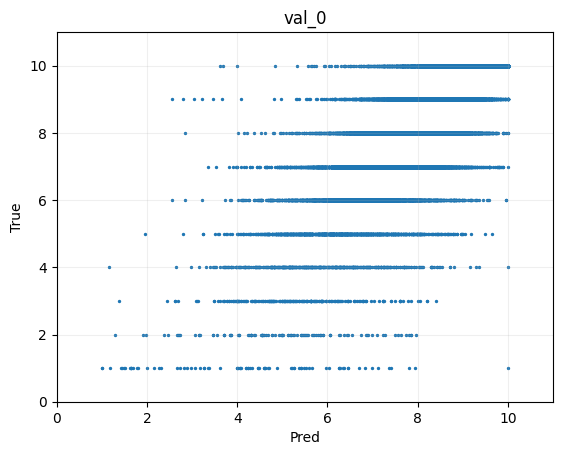

##############################
● CV1
##############################
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 1.15432
[1000]	valid_0's rmse: 1.13859
[1500]	valid_0's rmse: 1.1305
[2000]	valid_0's rmse: 1.12532
[2500]	valid_0's rmse: 1.12187
[3000]	valid_0's rmse: 1.1193
[3500]	valid_0's rmse: 1.11743
[4000]	valid_0's rmse: 1.11565
[4500]	valid_0's rmse: 1.11459
[5000]	valid_0's rmse: 1.11364
[5500]	valid_0's rmse: 1.11302
[6000]	valid_0's rmse: 1.11237
[6500]	valid_0's rmse: 1.11189
[7000]	valid_0's rmse: 1.11155
[7500]	valid_0's rmse: 1.11143
[8000]	valid_0's rmse: 1.1113
[8500]	valid_0's rmse: 1.11132
Early stopping, best iteration is:
[8265]	valid_0's rmse: 1.11121


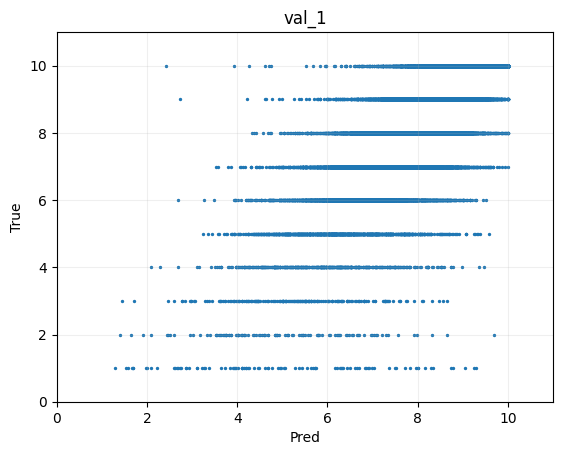

##############################
● CV2
##############################
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 1.14625
[1000]	valid_0's rmse: 1.13109
[1500]	valid_0's rmse: 1.12395
[2000]	valid_0's rmse: 1.11902
[2500]	valid_0's rmse: 1.11548
[3000]	valid_0's rmse: 1.11317
[3500]	valid_0's rmse: 1.11151
[4000]	valid_0's rmse: 1.11014
[4500]	valid_0's rmse: 1.10892
[5000]	valid_0's rmse: 1.10843
[5500]	valid_0's rmse: 1.10801
[6000]	valid_0's rmse: 1.10762
[6500]	valid_0's rmse: 1.10744
[7000]	valid_0's rmse: 1.1075
Early stopping, best iteration is:
[6667]	valid_0's rmse: 1.10741


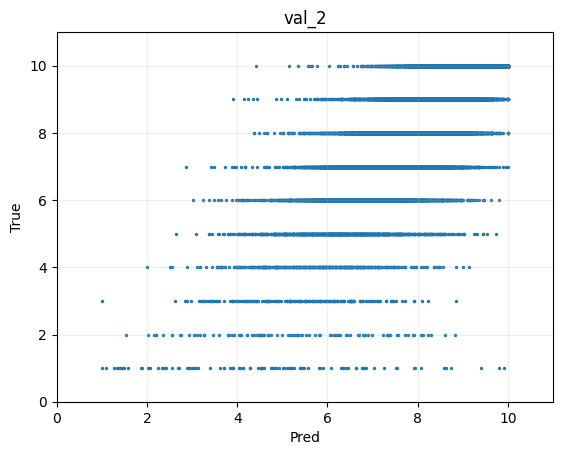

##############################
● CV3
##############################
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 1.1446
[1000]	valid_0's rmse: 1.12971
[1500]	valid_0's rmse: 1.12249
[2000]	valid_0's rmse: 1.11766
[2500]	valid_0's rmse: 1.11446
[3000]	valid_0's rmse: 1.11218
[3500]	valid_0's rmse: 1.11068
[4000]	valid_0's rmse: 1.10939
[4500]	valid_0's rmse: 1.1082
[5000]	valid_0's rmse: 1.10727
[5500]	valid_0's rmse: 1.10684
[6000]	valid_0's rmse: 1.10668
[6500]	valid_0's rmse: 1.10654
[7000]	valid_0's rmse: 1.10651
[7500]	valid_0's rmse: 1.10652
Early stopping, best iteration is:
[7395]	valid_0's rmse: 1.10647


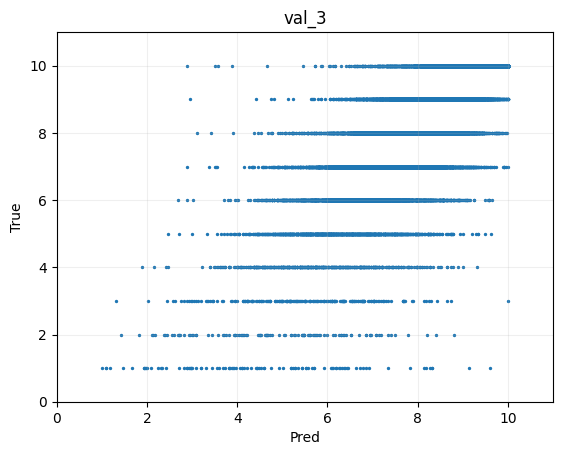

##############################
● CV4
##############################
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 1.15542
[1000]	valid_0's rmse: 1.13943
[1500]	valid_0's rmse: 1.13203
[2000]	valid_0's rmse: 1.12672
[2500]	valid_0's rmse: 1.1229
[3000]	valid_0's rmse: 1.11996
[3500]	valid_0's rmse: 1.11817
[4000]	valid_0's rmse: 1.11664
[4500]	valid_0's rmse: 1.11578
[5000]	valid_0's rmse: 1.11508
[5500]	valid_0's rmse: 1.11461
[6000]	valid_0's rmse: 1.11419
[6500]	valid_0's rmse: 1.11413
[7000]	valid_0's rmse: 1.1141
[7500]	valid_0's rmse: 1.11402
[8000]	valid_0's rmse: 1.11405
Early stopping, best iteration is:
[7616]	valid_0's rmse: 1.11396


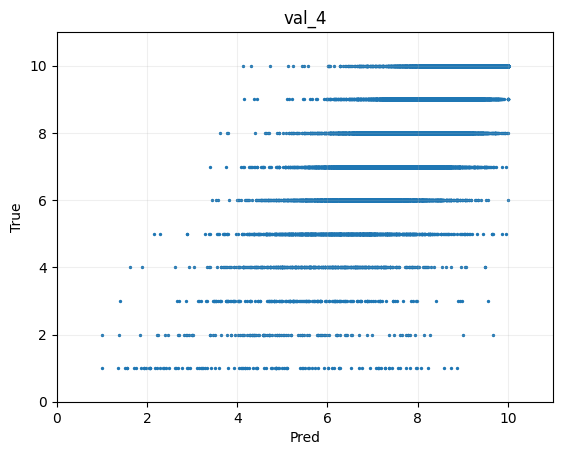

##############################
学習曲線
##############################


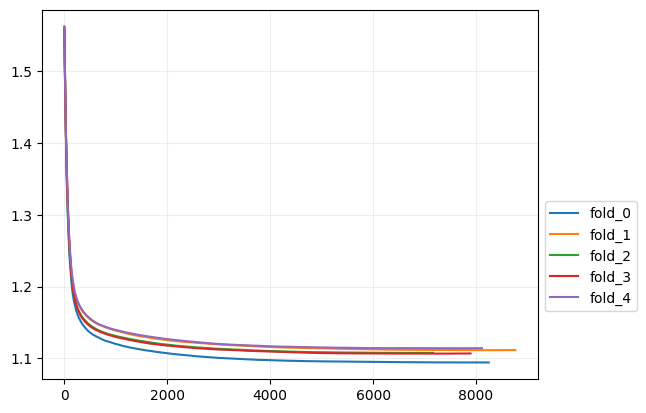

In [ ]:
results_rmse_kfold, fi_df_kfold = my_cross_val_predict_kfold(train, test, y_name="score", params=params_seen, features=features_seen)

(5, 279)


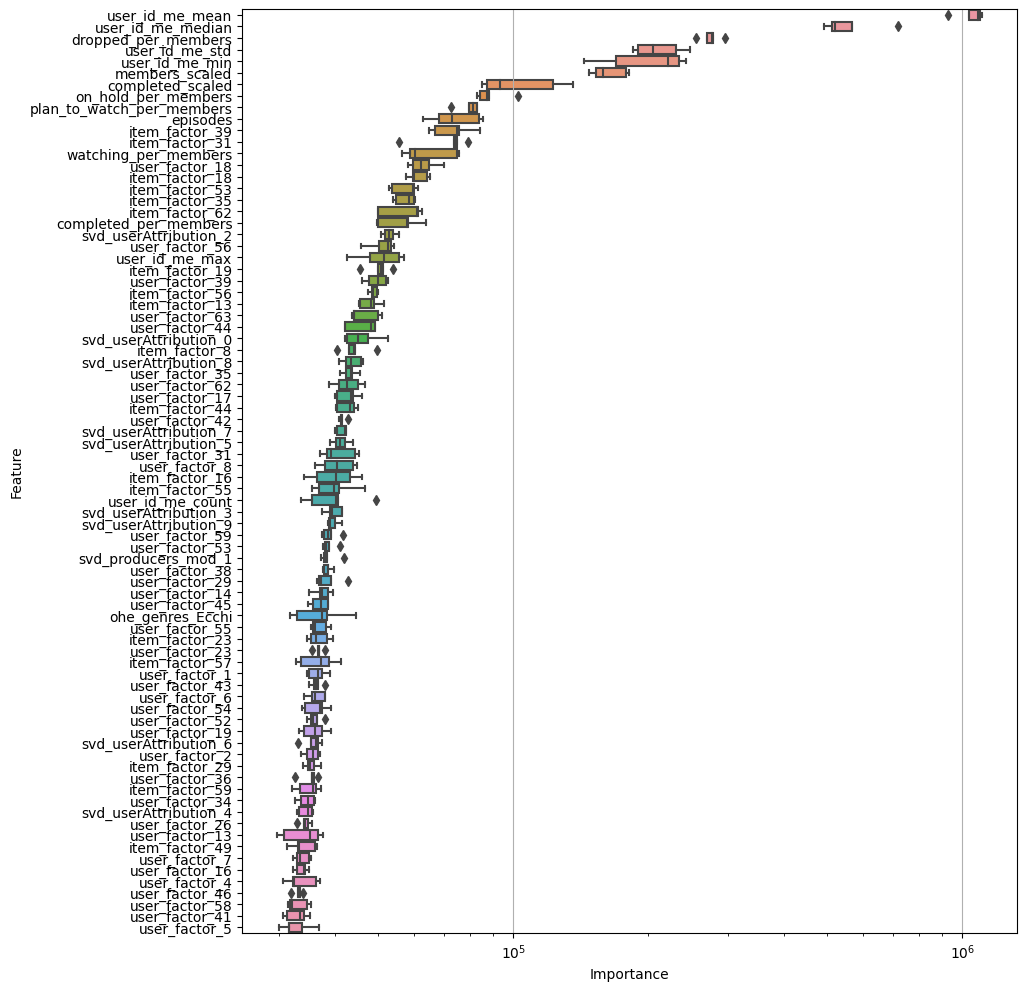

In [ ]:
plot_importance(fi_df_kfold, figsize=(10, 12))

## unseen

In [ ]:
params_unseen = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 13,
    'n_estimators': 20000,
    'learning_rate': 0.01,
    'num_leaves': 100,
    'colsample_bytree': 0.3,
    # 'subsample': 0.5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

##############################
● CV0
##############################
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 1.43143
[1000]	valid_0's rmse: 1.43098
Early stopping, best iteration is:
[666]	valid_0's rmse: 1.43044


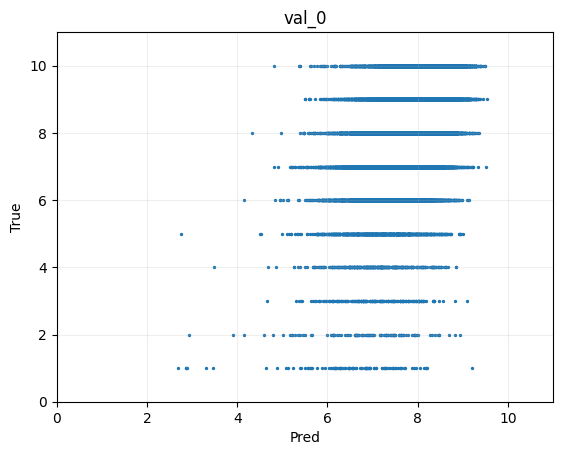

##############################
● CV1
##############################
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 1.36578
[1000]	valid_0's rmse: 1.35892
[1500]	valid_0's rmse: 1.35771
[2000]	valid_0's rmse: 1.35731
[2500]	valid_0's rmse: 1.3575
Early stopping, best iteration is:
[2137]	valid_0's rmse: 1.3571


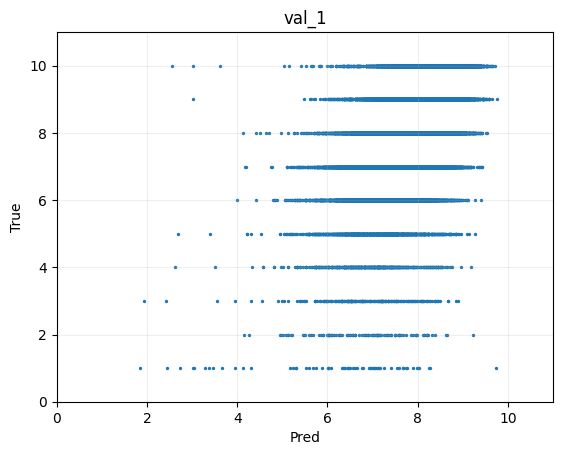

##############################
● CV2
##############################
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 1.41013
[1000]	valid_0's rmse: 1.40476
[1500]	valid_0's rmse: 1.40367
[2000]	valid_0's rmse: 1.403
[2500]	valid_0's rmse: 1.40306
Early stopping, best iteration is:
[2320]	valid_0's rmse: 1.40291


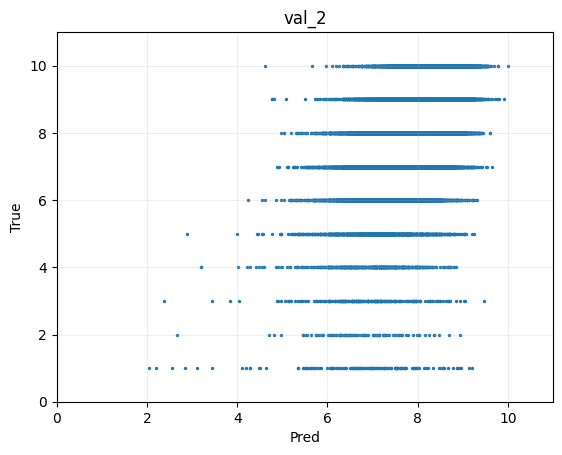

##############################
● CV3
##############################
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 1.37412
[1000]	valid_0's rmse: 1.36845
[1500]	valid_0's rmse: 1.36801
[2000]	valid_0's rmse: 1.36779
Early stopping, best iteration is:
[1989]	valid_0's rmse: 1.36772


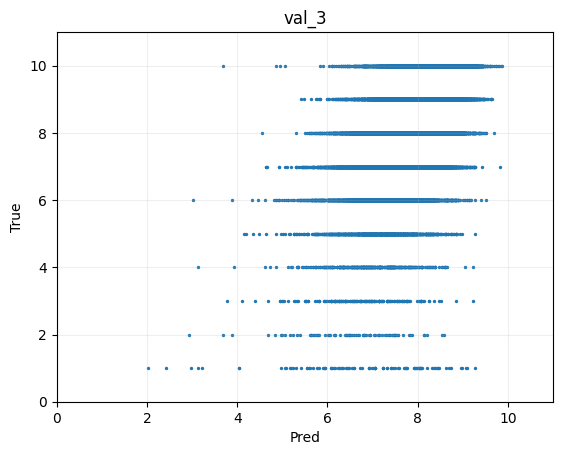

##############################
● CV4
##############################
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 1.36964
[1000]	valid_0's rmse: 1.36032
[1500]	valid_0's rmse: 1.35814
[2000]	valid_0's rmse: 1.35752
[2500]	valid_0's rmse: 1.35728
[3000]	valid_0's rmse: 1.35732
Early stopping, best iteration is:
[2642]	valid_0's rmse: 1.35718


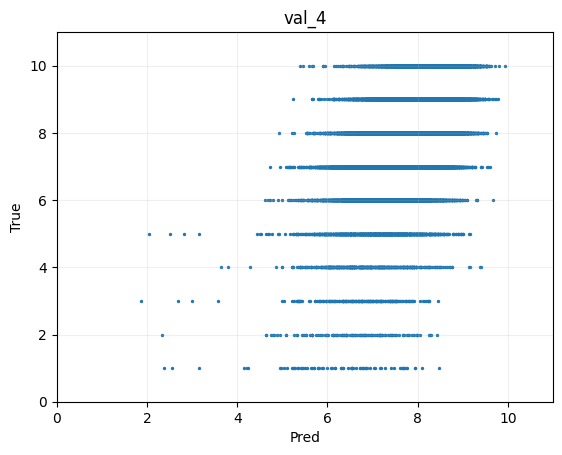

##############################
学習曲線
##############################


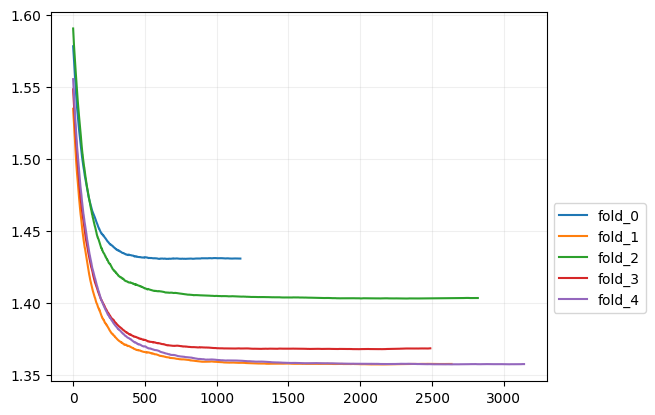

In [ ]:
# user_idにラベルを付ける
dict_label_user_id = {}
for i, id in enumerate(train["user_id"].unique()):
    dict_label_user_id[id] = i
train["label_user_id"] = train["user_id"].map(dict_label_user_id)

results_rmse_stratified, fi_df_stratified = my_cross_val_predict_StratifiedKFold(train, test, y_name="score", params=params_unseen, features=features_unseen)

(5, 273)


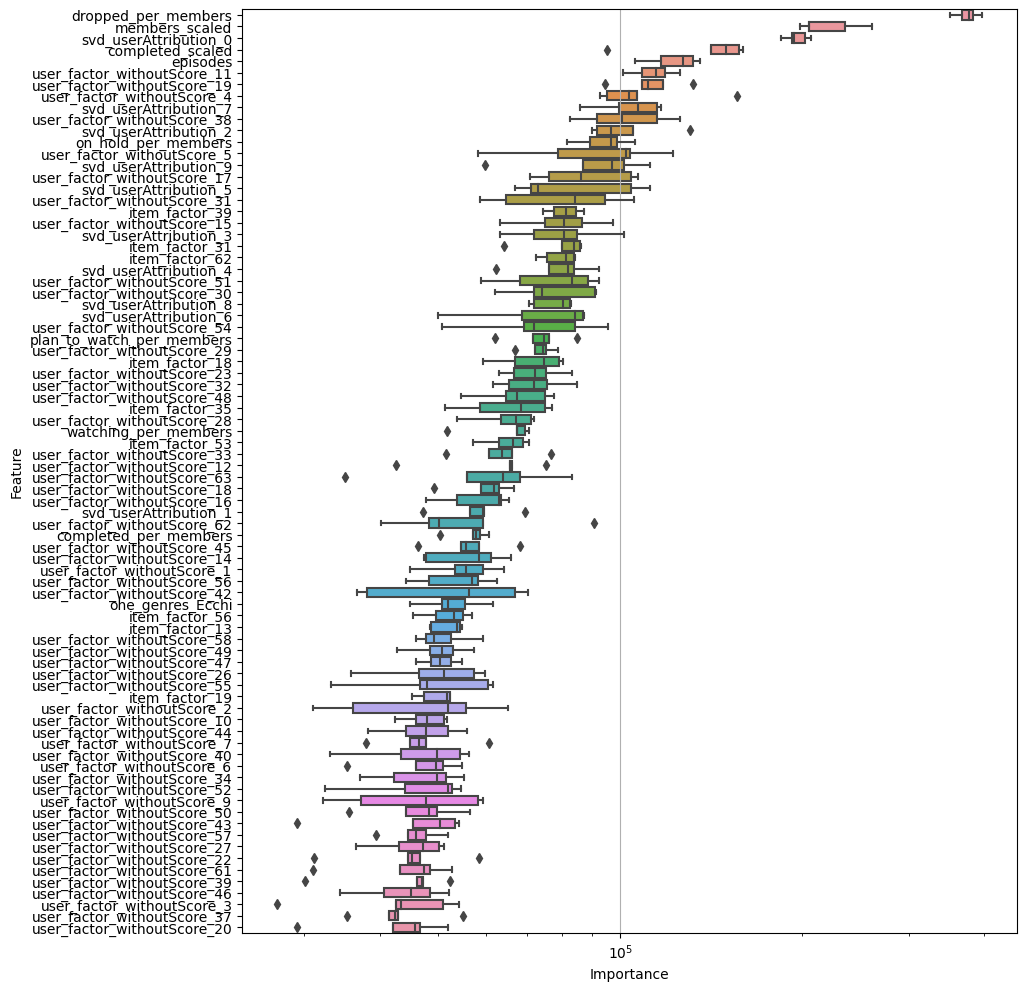

In [ ]:
plot_importance(fi_df_stratified, figsize=(10, 12))

## CV結果まとめ

●CV0: 
 rmse_final: 1.179, rmse_seen: 1.094, rmse_unseen: 1.430, 
●CV1: 
 rmse_final: 1.171, rmse_seen: 1.111, rmse_unseen: 1.357, 
●CV2: 
 rmse_final: 1.181, rmse_seen: 1.107, rmse_unseen: 1.403, 
●CV3: 
 rmse_final: 1.171, rmse_seen: 1.106, rmse_unseen: 1.368, 
●CV4: 
 rmse_final: 1.174, rmse_seen: 1.114, rmse_unseen: 1.357, 


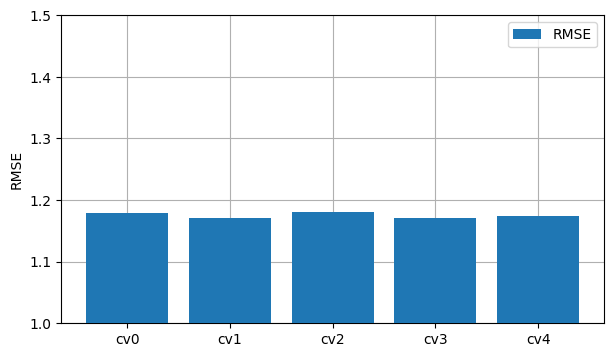

In [ ]:
# https://www.guruguru.science/competitions/21/discussions/3e3f5be8-7414-439a-b79f-f3d7e004d920/
c_seen = 0.7726469288555016
c_unseen = 0.22735307114449846

list_rmse_final = []
for i, (rmse_k, rmse_s)  in enumerate(zip(results_rmse_kfold, results_rmse_stratified)):
    rmse_final = np.sqrt(c_seen * rmse_k**2 + c_unseen * rmse_s**2)
    print(f"●CV{i}: ")
    print(f" rmse_final: {rmse_final:.3f}, rmse_seen: {rmse_k:.3f}, rmse_unseen: {rmse_s:.3f}, ")
    list_rmse_final.append(rmse_final)
plot_results(list_rmse_final, ylim=[1, 1.5])

# Sub

In [ ]:
def my_test_predict(train, test, y_name=None, params_seen=None, params_unseen=None, features_seen=None, features_unseen=None):
    # Mean Encoding
    df_me, train = mean_encoding_train(train, "user_id")
    test = mean_encoding_test(test, "user_id", df_me)
    # Mean Encoding (anime_id)
    # df_me, train = mean_encoding_train(train, "anime_id")
    # test = mean_encoding_test(test, "anime_id", df_me)
    # Mean Encoding (anime_type)
    df_me, train = mean_encoding_train(train, "label_type")
    test = mean_encoding_test(test, "label_type", df_me)
    # Mean Encoding (anime_source)
    df_me, train = mean_encoding_train(train, "label_source")
    test = mean_encoding_test(test, "label_source", df_me)
    # Mean Encoding (anime_rating)
    df_me, train = mean_encoding_train(train, "label_rating")
    test = mean_encoding_test(test, "label_rating", df_me)

    test1 = test[test["user_id_me_mean"]!=-100]
    test2 = test[test["user_id_me_mean"]==-100]

    assert len(test1) != 0
    assert len(test2) != 0

    X_train1 = train[features_seen].values
    X_train2 = train[features_unseen].values
    y_train = train[y_name].values
    X_test1 = test1[features_seen].values
    X_test2 = test2[features_unseen].values

    train_dataset1 = lgb.Dataset(X_train1,
                                 y_train,
                                 feature_name=features_seen)
    train_dataset2 = lgb.Dataset(X_train2,
                                 y_train,
                                 feature_name=features_unseen)
    # モデル作成
    model1 = lgb.train(params=params_seen,
                       train_set=train_dataset1)
    model2 = lgb.train(params=params_unseen,
                       train_set=train_dataset2)

    test1["pred"] = model1.predict(X_test1)
    test2["pred"] = model2.predict(X_test2)
    test_pred = pd.concat((
        test1[["user_id", "anime_id", "pred"]],
        test2[["user_id", "anime_id", "pred"]],
    )).reset_index(drop=True)

    # 予測値修正
    test_pred["pred"] = np.clip(test_pred["pred"].values, 1, 10)

    return test_pred

In [ ]:
params_seen = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 14,
    'n_estimators': 8500,
    'learning_rate': 0.015,
    'num_leaves': 200,
    'colsample_bytree': 0.3,
    # 'subsample': 0.5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': SEED,
}

params_unseen = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 13,
    'n_estimators': 1700,
    'learning_rate': 0.01,
    'num_leaves': 100,
    'colsample_bytree': 0.3,
    # 'subsample': 0.5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': SEED,
}

if SAVE_SUB:
    test_pred = my_test_predict(train,
                                test,
                                y_name="score",
                                params_seen=params_seen,
                                params_unseen=params_unseen,
                                features_seen=features_seen,
                                features_unseen=features_unseen)

In [ ]:
if SAVE_SUB:
    test_predicted = pd.merge(
        test[["user_id", "anime_id"]],
        test_pred,
        on=["user_id", "anime_id"],
        how="left"
    ).rename(columns={"pred": "score"})
    assert test_predicted["score"].isnull().sum()==0
    display(test_predicted)

,user_id,anime_id,score
0,0008e10fb39e55447333,04068820a73e52dc3b32,7.895871
1,0008e10fb39e55447333,04a3d0b122b24965e909,8.127044
2,0008e10fb39e55447333,1447fe1f10b59912d6a8,6.320657
3,0008e10fb39e55447333,2622632598c68682afd5,8.481494
4,0008e10fb39e55447333,2701850c7216516fec46,2.567197
...,...,...,...
117671,ffe85a36cd20500faa58,f508b02efeac8ecb8cc0,8.701134
117672,ffe85a36cd20500faa58,f5b8ecea3beea4b82d79,8.246564
117673,ffe85a36cd20500faa58,f6c208226b6b69948053,8.150983
117674,ffe85a36cd20500faa58,fe67592c312fc1e17745,7.933503


In [ ]:
if SAVE_SUB:
    test_sub = test_predicted[["score"]]
    print("sub shape:", sub.shape)
    print("test_sub shape:", test_sub.shape)
    display(test_sub)

sub shape: (117676, 1)
test_sub shape: (117676, 1)


,score
0,7.895871
1,8.127044
2,6.320657
3,8.481494
4,2.567197
...,...
117671,8.701134
117672,8.246564
117673,8.150983
117674,7.933503


In [ ]:
if SAVE_SUB:
    test_sub.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}.csv", index=False)